In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import scipy as sc

In [2]:
img_size=(240, 320)
img_channels = 3
batch_size=32
epochs = 100
display_epochs = (0, 100)


In [3]:
model_name = 'depthwise_with_pooling_(32-64-126)_(64).tf'

In [4]:
train_size = 1000
validation_size = 500
test_size = 500

# Load the DataSet

Dataset citation:
- From Semi-Supervised to Transfer Counting of Crowds
C. C. Loy, S. Gong, and T. Xiang
in Proceedings of IEEE International Conference on Computer Vision, pp. 2256-2263, 2013 (ICCV)
- Cumulative Attribute Space for Age and Crowd Density Estimation
K. Chen, S. Gong, T. Xiang, and C. C. Loy
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, pp. 2467-2474, 2013 (CVPR, Oral)
- Crowd Counting and Profiling: Methodology and Evaluation
C. C. Loy, K. Chen, S. Gong, T. Xiang
in S. Ali, K. Nishino, D. Manocha, and M. Shah (Eds.), Modeling, Simulation and Visual Analysis of Crowds, Springer, vol. 11, pp. 347-382, 2013
- Feature Mining for Localised Crowd Counting
K. Chen, C. C. Loy, S. Gong, and T. Xiang
British Machine Vision Conference, 2012 (BMVC)

In [5]:
dataset_path = '/Users/olove/Library/CloudStorage/OneDrive-Personal/AI datasets/CrowdCounter'

In [6]:
labels_df = pd.read_csv(dataset_path + '/labels.csv')
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

,count,image_name
0,35,seq_000001.jpg
1,41,seq_000002.jpg
2,41,seq_000003.jpg
3,44,seq_000004.jpg
4,41,seq_000005.jpg
...,...,...
1995,27,seq_001996.jpg
1996,27,seq_001997.jpg
1997,25,seq_001998.jpg
1998,26,seq_001999.jpg


In [7]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)
display(labels_df)

,count,image_name
0,29,seq_001673.jpg
1,30,seq_001951.jpg
2,30,seq_000613.jpg
3,40,seq_000366.jpg
4,29,seq_000500.jpg
...,...,...
1995,30,seq_001088.jpg
1996,35,seq_000259.jpg
1997,45,seq_000996.jpg
1998,27,seq_000211.jpg


In [8]:
if (train_size+validation_size+test_size) != len(labels_df):
    print('Dataset size is different from specified class sizes')
    exit(1)

training_df = labels_df[:train_size]
validation_df = labels_df[train_size:train_size+validation_size].reset_index(drop=True)
test_df = labels_df[train_size+validation_size:].reset_index(drop=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    
)

x_col_name = 'image_name'
y_col_name = 'count'

train_generator = datagen.flow_from_dataframe(
    training_df, 
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validation_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

Found 1000 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


# Define the model

In [10]:
inputs = keras.Input(shape= img_size + (img_channels,))

## Custom Simple Covnet

Downsizing using strides instead of MaxPolling in order to conserve location data

In [11]:
def basic_covnet_block(input):
    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
    return x

## Custom Depthwise Seperable Convolution

In [12]:
def custom_depthwise_conv_block(input, sizes, repeat_per_size, stride = 1, pooling = False):
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(input)
    
    for size in sizes:
        for i in range(repeat_per_size - 1):
            x = layers.BatchNormalization()(x)
            x  = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x  = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, stride, padding='same', use_bias=False)(x)
        if pooling:
            x = layers.MaxPooling2D()(x)
        
    return x
        

# Output Layer

In [13]:
def basic_dense_block(covnet_param, sizes):
    x = layers.Flatten()(covnet_param)
    for size in sizes:
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    return outputs

In [14]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, pooling=True)
outputs = basic_dense_block(covnet, [])
model = keras.Model(inputs=inputs, outputs=outputs)

2023-12-13 16:19:50.193620: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-13 16:19:50.193648: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-13 16:19:50.193655: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-13 16:19:50.193996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-13 16:19:50.194184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 236, 316, 32)      2400      
                                                                 
 batch_normalization (Batch  (None, 236, 316, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 236, 316, 32)      0         
                                                                 
 separable_conv2d (Separabl  (None, 236, 316, 32)      1312      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 236, 316, 32)      128   

# Train model

In [16]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
# TODO: Try mae vs accuracy. mae should be better since we are adjusting it to get closer to the actual value

In [17]:
callbacks_list = [
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss", patience=4
#    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.TensorBoard()
]

In [18]:
Wsave = model.get_weights()

In [19]:
model.set_weights(Wsave)
history = model.fit(train_generator,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
)

Epoch 1/100


2023-12-13 16:19:51.398882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 98.2506 - mae: 6.9203 INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 21s 586ms/step - loss: 98.2506 - mae: 6.9203 - val_loss: 1016.7784 - val_mae: 31.1246
Epoch 2/100
32/32 [==============================] - 18s 563ms/step - loss: 14.6952 - mae: 3.0441 - val_loss: 1030.5388 - val_mae: 31.3449
Epoch 3/100
32/32 [==============================] - 17s 527ms/step - loss: 10.3155 - mae: 2.5366 - val_loss: 1044.3895 - val_mae: 31.5650
Epoch 4/100
32/32 [==============================] - 17s 541ms/step - loss: 7.1642 - mae: 2.1146 - val_loss: 1059.4845 - val_mae: 31.8033
Epoch 5/100
32/32 [==============================] - 25s 774ms/step - loss: 6.3918 - mae: 1.9975 - val_loss: 1069.8475 - val_mae: 31.9658
Epoch 6/100
32/32 [==============================] - 16s 495ms/step - loss: 4.6706 - mae: 1.7116 - val_loss: 1082.1510 - val_mae: 32.1578
Epoch 7/100
32/32 [==============================] - 16s 500ms/step - loss: 5.6468 - mae: 1.9076 - val_loss: 1085.3883 - val_mae: 32.2083
Epoch 8/100
32/32 [========================

INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 525ms/step - loss: 2.5947 - mae: 1.2936 - val_loss: 957.7336 - val_mae: 30.2367
Epoch 15/100
32/32 [==============================] - ETA: 0s - loss: 1.9600 - mae: 1.1348INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 16s 509ms/step - loss: 1.9600 - mae: 1.1348 - val_loss: 863.7098 - val_mae: 28.7004
Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 2.0773 - mae: 1.1569INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 16s 510ms/step - loss: 2.0773 - mae: 1.1569 - val_loss: 697.4324 - val_mae: 25.7588
Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 1.3309 - mae: 0.9193INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 16s 512ms/step - loss: 1.3309 - mae: 0.9193 - val_loss: 531.5930 - val_mae: 22.4538
Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 0.7782 - mae: 0.6943INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 18s 549ms/step - loss: 0.7782 - mae: 0.6943 - val_loss: 406.7906 - val_mae: 19.5997
Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 0.8099 - mae: 0.7248INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 18s 522ms/step - loss: 0.8099 - mae: 0.7248 - val_loss: 258.9691 - val_mae: 15.5718
Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 0.8462 - mae: 0.7529INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 525ms/step - loss: 0.8462 - mae: 0.7529 - val_loss: 221.9364 - val_mae: 14.3828
Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 1.3700 - mae: 0.9559INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 522ms/step - loss: 1.3700 - mae: 0.9559 - val_loss: 119.4265 - val_mae: 10.4104
Epoch 22/100
32/32 [==============================] - ETA: 0s - loss: 0.7060 - mae: 0.6878INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 539ms/step - loss: 0.7060 - mae: 0.6878 - val_loss: 69.5449 - val_mae: 7.7822
Epoch 23/100
32/32 [==============================] - ETA: 0s - loss: 0.6320 - mae: 0.6587INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 523ms/step - loss: 0.6320 - mae: 0.6587 - val_loss: 41.4478 - val_mae: 5.8292
Epoch 24/100
32/32 [==============================] - ETA: 0s - loss: 1.4309 - mae: 0.9746INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 18s 534ms/step - loss: 1.4309 - mae: 0.9746 - val_loss: 33.2806 - val_mae: 5.1735
Epoch 25/100
32/32 [==============================] - ETA: 0s - loss: 0.9799 - mae: 0.7929INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 18s 535ms/step - loss: 0.9799 - mae: 0.7929 - val_loss: 5.7628 - val_mae: 1.8667
Epoch 26/100
32/32 [==============================] - 17s 506ms/step - loss: 1.1444 - mae: 0.8667 - val_loss: 16.4180 - val_mae: 3.3501
Epoch 27/100
32/32 [==============================] - 16s 492ms/step - loss: 0.7410 - mae: 0.6992 - val_loss: 14.8821 - val_mae: 3.1149
Epoch 28/100
32/32 [==============================] - 15s 478ms/step - loss: 0.8526 - mae: 0.7618 - val_loss: 10.0695 - val_mae: 2.4523
Epoch 29/100
32/32 [==============================] - ETA: 0s - loss: 0.7183 - mae: 0.6757INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 517ms/step - loss: 0.7183 - mae: 0.6757 - val_loss: 5.7311 - val_mae: 1.8376
Epoch 30/100
32/32 [==============================] - 16s 483ms/step - loss: 1.1379 - mae: 0.8530 - val_loss: 8.7391 - val_mae: 2.2888
Epoch 31/100
32/32 [==============================] - 16s 488ms/step - loss: 1.1261 - mae: 0.8158 - val_loss: 6.2303 - val_mae: 1.9170
Epoch 32/100
32/32 [==============================] - ETA: 0s - loss: 0.8301 - mae: 0.7302INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 518ms/step - loss: 0.8301 - mae: 0.7302 - val_loss: 5.6062 - val_mae: 1.8299
Epoch 33/100
32/32 [==============================] - 17s 505ms/step - loss: 0.7198 - mae: 0.6856 - val_loss: 7.1384 - val_mae: 2.0275
Epoch 34/100
32/32 [==============================] - 16s 499ms/step - loss: 0.5756 - mae: 0.5744 - val_loss: 7.5898 - val_mae: 2.1142
Epoch 35/100
32/32 [==============================] - 16s 494ms/step - loss: 0.7982 - mae: 0.7439 - val_loss: 5.9122 - val_mae: 1.8875
Epoch 36/100
32/32 [==============================] - 16s 495ms/step - loss: 0.7453 - mae: 0.6850 - val_loss: 5.9240 - val_mae: 1.9079
Epoch 37/100
32/32 [==============================] - 16s 495ms/step - loss: 0.7699 - mae: 0.7156 - val_loss: 5.9712 - val_mae: 1.9314
Epoch 38/100
32/32 [==============================] - ETA: 0s - loss: 0.3582 - mae: 0.4708INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 515ms/step - loss: 0.3582 - mae: 0.4708 - val_loss: 5.4613 - val_mae: 1.8220
Epoch 39/100
32/32 [==============================] - 16s 495ms/step - loss: 0.8830 - mae: 0.7660 - val_loss: 5.9362 - val_mae: 1.8795
Epoch 40/100
32/32 [==============================] - 16s 490ms/step - loss: 0.3646 - mae: 0.4673 - val_loss: 6.8844 - val_mae: 2.1086
Epoch 41/100
32/32 [==============================] - 15s 473ms/step - loss: 0.2764 - mae: 0.4077 - val_loss: 6.0672 - val_mae: 1.8842
Epoch 42/100
32/32 [==============================] - 16s 488ms/step - loss: 0.2034 - mae: 0.3652 - val_loss: 5.7050 - val_mae: 1.8551
Epoch 43/100
32/32 [==============================] - 15s 480ms/step - loss: 0.3007 - mae: 0.4275 - val_loss: 5.9529 - val_mae: 1.8688
Epoch 44/100
32/32 [==============================] - 15s 475ms/step - loss: 0.4306 - mae: 0.5246 - val_loss: 7.5189 - val_mae: 2.1158
Epoch 45/100
32/32 [==============================] - 16s 482ms/step

In [20]:
model.evaluate(validation_generator)

16/16 [==============================] - 2s 89ms/step - loss: 5.9635 - mae: 1.8827


[5.963483810424805, 1.8826594352722168]

In [21]:
model.evaluate(test_generator)

16/16 [==============================] - 2s 89ms/step - loss: 5.5252 - mae: 1.8460


[5.52524471282959, 1.8460432291030884]

# Represent history

In [22]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


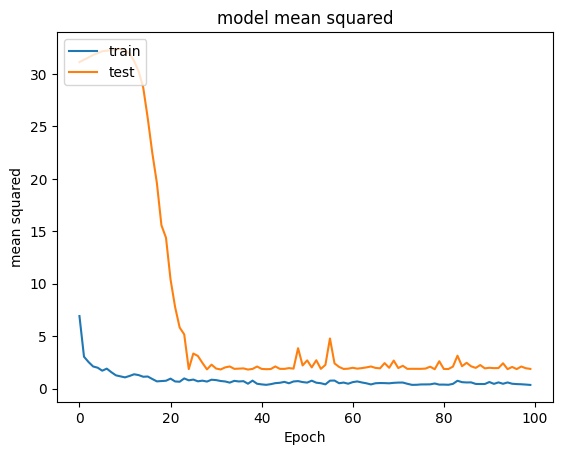

In [23]:
plt.plot(history.history['mae'][display_epochs[0]:display_epochs[1]])
plt.plot(history.history['val_mae'][display_epochs[0]:display_epochs[1]])
plt.title('model mean squared')
plt.ylabel('mean squared')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

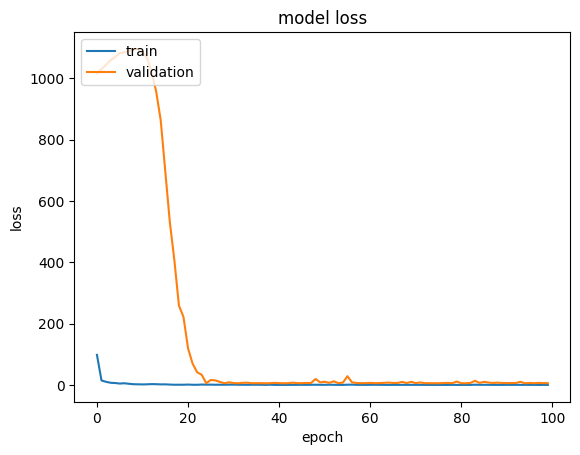

In [24]:
plt.plot(history.history['loss'][display_epochs[0]:display_epochs[1]])
plt.plot(history.history['val_loss'][display_epochs[0]:display_epochs[1]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Bibliografia

- Deep Learning with Python, Second Edition. François Chollet